
# Analyzing Fairness and Bias in Crime Prediction Models

This tutorial investigates bias and fairness in predictive policing models. 
Using the Communities and Crime dataset, we explore the implications of using potentially imbalanced data and propose methods for improving fairness.
The main objectives are:

- Understand how bias manifests in the dataset and predictive models.
- Evaluate fairness metrics to measure the impact of these biases.
- Explore techniques to mitigate bias and assess their effectiveness.

Let's begin by exploring the dataset and understanding its structure.


In [ ]:
! pip install ucimlrepo
! pip install matplotlib
! pip install scikit-learn
! pip install seaborn

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import warnings

In [2]:
# Silence all warnings
warnings.filterwarnings('ignore')

#### **Load Dataset**

In [3]:
# fetch dataset 
communities_and_crime = fetch_ucirepo(id=183) 
  
# data (as pandas dataframes) 
X = communities_and_crime.data.features 
y = communities_and_crime.data.targets 
 
# metadata 
metadata = communities_and_crime.metadata
  
# variable information 
variables = communities_and_crime.variables

print(metadata)
print(variables)

{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'ID': 405, 'type': 'NATIVE', 'title': 'A data-driven software tool for enabling cooperative information s

In [4]:
# Convert to a dataframe
df = pd.concat([X, y], axis=1)

df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [5]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Check for missing values again
print(df.isnull().sum())

state                     0
county                 1174
community              1177
communityname             0
fold                      0
                       ... 
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
Length: 128, dtype: int64


### **Data Preprocessing**

The `community` column represents unique identifiers for each community. Although the values are numeric, they should not be treated as continuous or ordinal variables. This is because the numeric values in the `community` column are simply community identifiers, meaning there is no magnitude relationship between them. If we treated the `community` column as a continuous or ordinal variable, the Random Forest model could interpret comparisons like 17 > 2 or 17 - 2 = 15, which doesn't make sense in this context. The model could mistakenly compare these communities based on numeric values, leading to incorrect conclusions. For this reason, we will remove it.

The `communityname` column contains the names of the communities. This column is a categorical variable represented as text, meaning it needs to be converted to a numeric form to be used in models like Random Forest, which require numeric data to perform splits and calculations. The model cannot process strings directly, so we need to either remove or encode this variable before feeding it into the model. Otherwise, the algorithm would not know how to handle this text column. For this reason, we will remove it.

The `state` column is numeric and contains codes that represent the states where the communities are located. These codes are not ordinal, meaning there is no inherent order between them (for example, code 1 does not mean it is more "important" or "larger" than code 2). Since `state` is a categorical numeric variable (with codes representing states), the most appropriate technique to handle it is One-Hot Encoding. This transformation converts each state code into a new binary column (0 or 1), where each row indicates the presence or absence of a specific state for each community. Although `state` is numeric, this technique is used to prevent the model from incorrectly interpreting numeric codes as ordinal. The model could, inappropriately, try to compare state codes as if they were continuous or ordinal variables (for example, 1 > 2). Thus, One-Hot Encoding resolves this by treating each state as an independent category.

Before removing the `community`, because it has Nan values, and `communityname` columns, we will store this information in dictionaries so that, if we need to refer to or use it in future analyses (such as interpreting the results), we can easily access it.
- The `community` dictionary maps each community code (which is a unique number) to the associated community name.
- The `state` dictionary maps each state code to a list of communities that belong to that state. In other words, the `state` dictionary will store which communities are located in which states, associating the state code with the corresponding communities.




In [6]:
# Filtrar as linhas onde `community` e `communityname` não são NaN
valid_data = df[['community', 'communityname']].dropna(subset=['community', 'communityname'])

# Criar o dicionário
community_mapping = dict(zip(valid_data['community'], valid_data['communityname']))
print(community_mapping)

{'81440': 'Willingborotownship', '6096': 'Bethlehemtownship', '41500': 'Lincolntown', '44105': 'Needhamtown', '30075': 'GrandChutetown', '91370': 'FortDodgecity', '1000': 'Alexandriacity', '17650': 'Denvilletownship', '66376': 'Rostravertownship', '93926': 'SiouxCitycity', '61798': 'Perrytownship', '22490': 'EastHamptontown', '47672': 'Lynchburgcity', '59280': 'Plainsborotownship', '40560': 'LittleEggHarbortownship', '22960': 'EastProvidencecity', '55950': 'Paramusborough', '81740': 'Winslowtownship', '12900': 'Claremontcity', '57660': 'Pennsaukentownship', '45120': 'Medfordtownship', '43620': 'Manvilleborough', '30570': 'Hawthorneborough', '75216': 'Stauntoncity', '42750': 'Mahwahtownship', '58200': 'PerthAmboycity', '54837': 'Oneidacity', '34950': 'Guilfordtown', '46520': 'Meridentown', '82525': 'Yarmouthtown', '84000': 'Yonkerscity', '63968': 'Polandtownship', '66700': 'Vermillioncity', '22240': 'EastGreenwichtown', '37875': 'Maldencity', '87560': 'Wolcotttown', '45140': 'Manchester

In [7]:
# Criar um dicionário que mapeia as comunidades para seus respectivos estados
# Filtra as linhas sem NaN nas colunas 'community' e 'state' e elimina duplicatas
community_to_state = df[['community', 'state']].dropna().drop_duplicates()

# Criar o dicionário de mapeamento
community_to_state_mapping = dict(zip(community_to_state['community'], community_to_state['state']))

# Exibir o dicionário resultante
print(community_to_state_mapping)

{'81440': 34, '6096': 42, '41500': 44, '44105': 25, '30075': 55, '91370': 19, '1000': 51, '17650': 34, '66376': 42, '93926': 19, '61798': 39, '22490': 9, '47672': 51, '59280': 34, '40560': 34, '22960': 44, '55950': 34, '81740': 34, '12900': 33, '57660': 34, '45120': 34, '43620': 34, '30570': 34, '75216': 51, '42750': 34, '58200': 34, '54837': 36, '34950': 9, '46520': 9, '82525': 25, '84000': 36, '63968': 39, '66700': 46, '22240': 44, '37875': 25, '87560': 9, '45140': 33, '76490': 34, '73060': 46, '83080': 42, '83432': 42, '20100': 25, '80240': 34, '47616': 42, '66060': 34, '21504': 39, '39300': 33, '58730': 39, '45056': 42, '22456': 39, '4825': 25, '13690': 34, '51660': 34, '79740': 25, '66660': 33, '75740': 34, '37000': 25, '62432': 42, '20080': 44, '56550': 34, '7310': 9, '7665': 25, '16495': 25, '70020': 34, '54040': 39, '74880': 42, '37490': 25, '82000': 51, '32296': 42, '36000': 34, '70380': 39, '5320': 34, '44700': 9, '53104': 42, '56966': 39, '18070': 34, '38715': 25, '48955': 2

In [8]:
# Drop features that are redundant or less relevant according to the domain knowledge
columns_to_drop = [
    'communityname', 
    'state', 
    'community', 
    'communityname',
    'numbUrban',  # Keep only 'pctUrban'
    'NumIlleg',  # Keep 'PctIlleg'
    'PctImmigRec10', 'PctImmigRec5', 'PctImmigRec8',  # Keep 'PctRecImmig5' and 'PctRecImmig10'
    'PctSpeakEnglOnly',  # Keep 'PctNotSpeakEnglWell' PctSpeakEnglOnly
]

# Drop the unnecessary columns
df = df.drop(columns=columns_to_drop, errors='ignore')

In [9]:
# Remover as colunas com valores ausentes
df = df.dropna(axis=1)

In [10]:
list(df.columns)

['fold',
 'population',
 'householdsize',
 'racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'agePct65up',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'HispPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PersPerFam',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctRecentImmig',
 'PctRecImmig5',
 'PctRecImmig8',
 'PctRecImmig10',
 'PctNotSpeakEnglWell',
 'PctLargHouseFam',
 'PctLargHouseOccup',
 'PersPerOccupHous',
 'PersPerOwn

#### **Remove correlation features**
- **Reduction of redundancy:** Highly correlated variables carry similar information. So, keeping both can increase dimensionality without adding value.

- **Improved interpretability:** Fewer features make the model easier to understand.

- **Avoiding overfitting:** High dimensionality and redundancy increase the risk of overfitting, especially with small datasets.

- **Reduced complexity:** Random Forest uses decision trees, which can become more complex with correlated variables.

- **Performance improvement:** By reducing redundancy, the model can converge more quickly and efficiently, improving accuracy.

- **Bias and fairness:** By removing variables related to sensitive attributes, we can mitigate potential biases in the model.

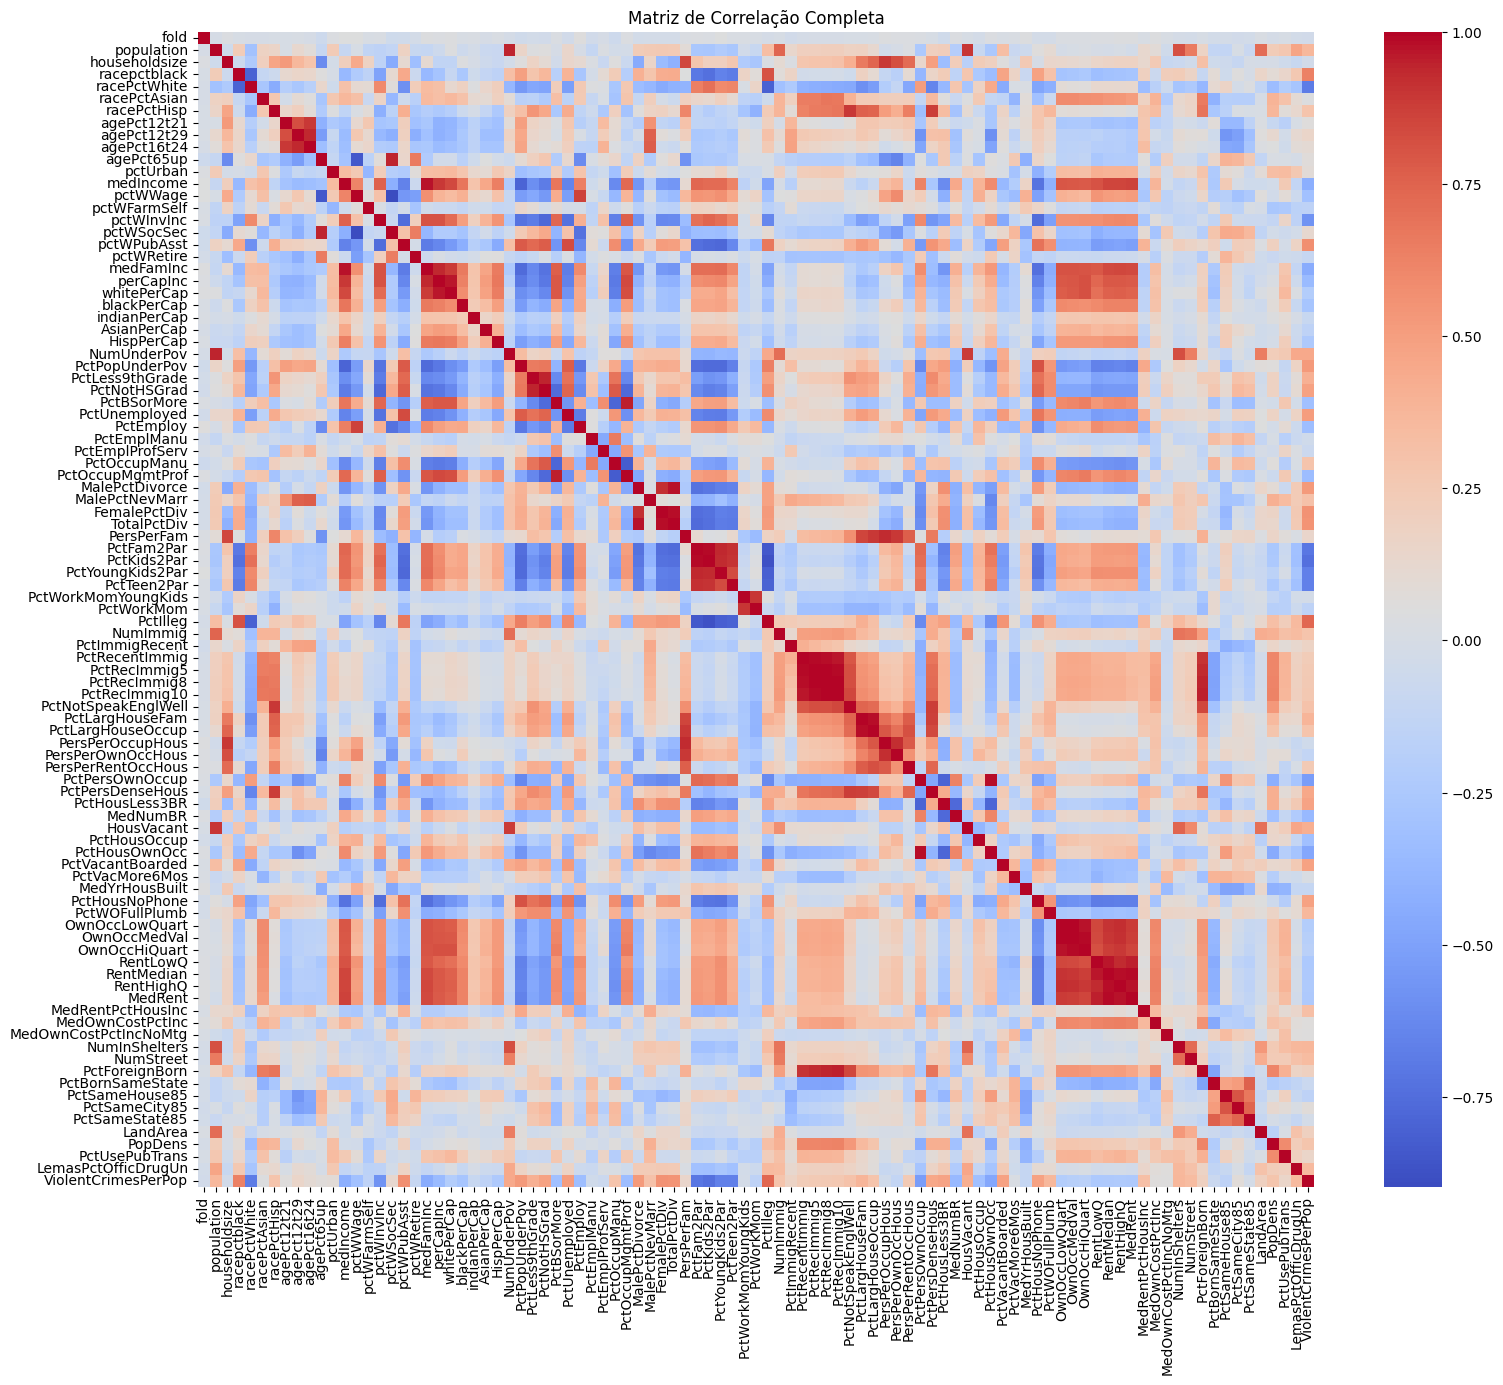

In [11]:
correlation_matrix = df.corr()

# 2. Visualizar a matriz completa
plt.figure(figsize=(18, 15))
# Plotar o heatmap com rótulos no eixo
sns.heatmap(
    correlation_matrix,
    annot=False,  # Não exibir valores diretamente
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    xticklabels=correlation_matrix.columns,  # Garantir os rótulos no eixo x
    yticklabels=correlation_matrix.columns   # Garantir os rótulos no eixo y
)
plt.title("Matriz de Correlação Completa")
plt.show()

In [12]:
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

In [13]:
# Find and display columns to drop alongside the column they are highly correlated with
highly_correlated_pairs = []

for column in upper_triangle.columns:
    correlated_with = upper_triangle.index[upper_triangle[column] > 0.95].tolist()
    if correlated_with:
        for correlated_col in correlated_with:
            highly_correlated_pairs.append((correlated_col, column))  # Keep correlated_col, drop column

# Print the pairs (kept column, dropped column)
for keep, drop in highly_correlated_pairs:
    print(f"Keeping: {keep}, Dropping: {drop}")

Keeping: medIncome, Dropping: medFamInc
Keeping: perCapInc, Dropping: whitePerCap
Keeping: PctBSorMore, Dropping: PctOccupMgmtProf
Keeping: MalePctDivorce, Dropping: TotalPctDiv
Keeping: FemalePctDiv, Dropping: TotalPctDiv
Keeping: PctFam2Par, Dropping: PctKids2Par
Keeping: PctRecentImmig, Dropping: PctRecImmig5
Keeping: PctRecentImmig, Dropping: PctRecImmig8
Keeping: PctRecImmig5, Dropping: PctRecImmig8
Keeping: PctRecentImmig, Dropping: PctRecImmig10
Keeping: PctRecImmig5, Dropping: PctRecImmig10
Keeping: PctRecImmig8, Dropping: PctRecImmig10
Keeping: PctLargHouseFam, Dropping: PctLargHouseOccup
Keeping: PctPersOwnOccup, Dropping: PctHousOwnOcc
Keeping: OwnOccLowQuart, Dropping: OwnOccMedVal
Keeping: OwnOccLowQuart, Dropping: OwnOccHiQuart
Keeping: OwnOccMedVal, Dropping: OwnOccHiQuart
Keeping: RentLowQ, Dropping: RentMedian
Keeping: RentMedian, Dropping: RentHighQ
Keeping: RentMedian, Dropping: MedRent
Keeping: RentHighQ, Dropping: MedRent
Keeping: PctRecImmig10, Dropping: PctForeig

In [14]:
to_drop = list(set([pair[1] for pair in highly_correlated_pairs]))
to_drop = [feature for feature in to_drop if feature != 'WhitePerCap']

# Imprimir a lista final de colunas a serem removidas
print(f"Total de features a serem removidas: {len(to_drop)}")

Total de features a serem removidas: 16


In [15]:
# Criar um novo DataFrame removendo as features identificadas
df = df.drop(columns=to_drop, errors='ignore')

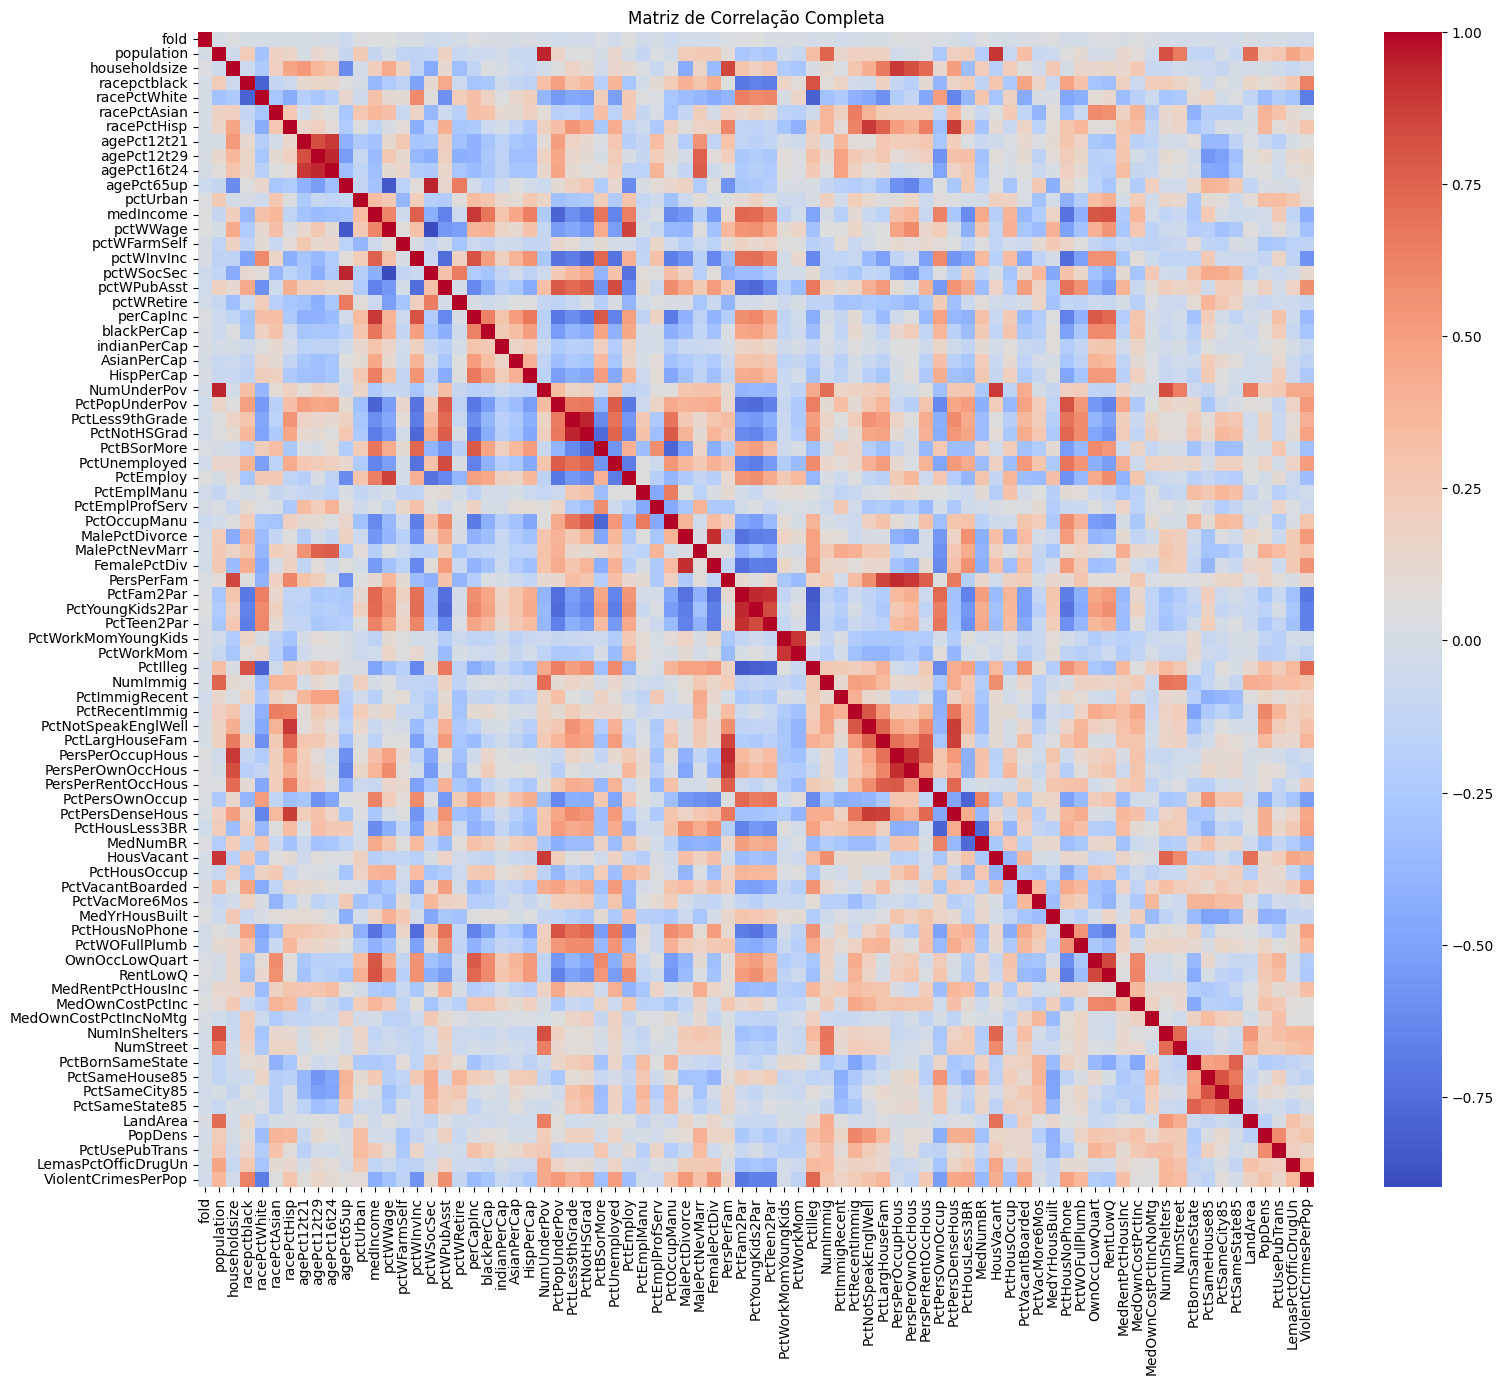

In [16]:
correlation_matrix = df.corr()

# 2. Visualizar a matriz completa
plt.figure(figsize=(18, 15))
# Plotar o heatmap com rótulos no eixo
sns.heatmap(
    correlation_matrix,
    annot=False,  # Não exibir valores diretamente
    cmap="coolwarm",
    fmt=".2f",
    cbar=True,
    xticklabels=correlation_matrix.columns,  # Garantir os rótulos no eixo x
    yticklabels=correlation_matrix.columns   # Garantir os rótulos no eixo y
)
plt.title("Matriz de Correlação Completa")
plt.show()

#### **Enconding Target Column**

In order to perform classification, we need to transform the continuous target column into a multi-class target column.

To do that, we define 3 intervals ( [0.0-0.35[, [0.35-0.65], ]0.65-1.0] ) and encode all 3 string intervals into numeric classes (0,1,2) so it would be easy to perform classification.

In [17]:
# Define the bins (intervals) and labels
bins = [0.0, 0.35, 0.65, 1.0]  # Bin edges
labels = ['[0.0-0.35[', '[0.35-0.65]', ']0.65-1.0]']  # Class labels

# Transform the continuous column into a multi-class column
df['ViolentCrimesPerPop-Final'] = pd.cut(df['ViolentCrimesPerPop'], bins=bins, labels=labels, include_lowest=True)

In [18]:
# Encode the string intervals into numeric classes
label_encoder = LabelEncoder()
df['ViolentCrimesPerPop-Final'] = label_encoder.fit_transform(df['ViolentCrimesPerPop-Final'])

# Display mapping of classes
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'[0.0-0.35[': np.int64(0), '[0.35-0.65]': np.int64(1), ']0.65-1.0]': np.int64(2)}


In [19]:
df = df.drop(columns=['ViolentCrimesPerPop'])

## **Model Predict**

#### **Demographic Analysis**

In [20]:
X = df.drop(columns= ['fold', 'ViolentCrimesPerPop-Final', 'racepctblack', 'racePctAsian', 'racePctHisp'], axis=1)
y = df['ViolentCrimesPerPop-Final']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

model = RandomForestClassifier(max_depth=10, random_state=42)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("Test Confusion Matrix:")
print(test_conf_matrix)

Test Confusion Matrix:
[[596  14   8]
 [ 71  45  12]
 [ 16  15  21]]


In [22]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test  -> Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

Test  -> Accuracy: 0.8296, Precision: 0.8067, Recall: 0.8296, F1: 0.8104


With the obtained values we can do the following analysis:
- Accuracy: 0.8271: indicates that the model correctly predicts approximately 82.7% of the test samples.
- Precision: 0.8036: precision measures how many of the predicted positive cases are truly positive. The weighted average precision reflects class imbalances.
- Class 0: Predicted correctly 595 times, with minimal misclassification.
- Class 1: Struggles to classify correctly, with a noticeable number of false negatives and false positives.
- Class 2: Underrepresented in correct predictions, with a high rate of misclassification.
This imbalance suggests potential fairness issues if these classes represent groups with demographic or social significance.

#### **Breaking down the confusion matrix per class**

In [23]:
def confusion_matrix_per_class(y_true, y_pred, class_labels):
    for cls in class_labels:
        print(f"\nConfusion Matrix for class {cls}:")
        # Transformar a classe de interesse em 1 e o resto em 0
        y_true_bin = np.where(y_true == cls, 1, 0)
        y_pred_bin = np.where(y_pred == cls, 1, 0)
        # Calcular matriz de confusão
        conf_matrix = confusion_matrix(y_true_bin, y_pred_bin)
        print(conf_matrix)

# Obter os rótulos únicos das classes
class_labels = np.unique(y_test)

# Calcular matriz de confusão para cada classe
confusion_matrix_per_class(y_test, y_test_pred, class_labels)

"""
 TN.  FP
 FN  TP
"""


Confusion Matrix for class 0:
[[ 93  87]
 [ 22 596]]

Confusion Matrix for class 1:
[[641  29]
 [ 83  45]]

Confusion Matrix for class 2:
[[726  20]
 [ 31  21]]


'\n TN.  FP\n FN  TP\n'

For class 0:
- `True Negative (TN = 93):` Cases where the true class is not 0 (belongs to Class 1 or 2) and the model correctly predicted it as not being 0.
For 93 samples that belong to Classes 1 or 2, the model correctly predicted that they are not Class 0. This reflects a moderate ability to distinguish Class 0 from Classes 1 and 2.
- `False Positive (FP = 57):` Cases where the true class is not 0 (belongs to Class 1 or 2), but the model incorrectly predicted it as 0.
In 57 cases, the model incorrectly classified instances of Classes 1 and 2 as Class 0. This shows a weakness in specificity, as the model sometimes misclassifies other classes as 0.
- `False Negative (FN = 22):` Cases where the true class is 0, but the model incorrectly predicted it as not 0 (grouped as Class 1 or 2).
In 22 cases, the model failed to classify instances of Class 0, grouping them with Classes 1 and 2. This relatively low number suggests that the model performs well in recognizing Class 0.
- `True Positive (TP = 596):` Cases where the true class is 0, and the model correctly predicted it as 0.
The model successfully identifies a significant proportion of Class 0 cases. This indicates high sensitivity (recall) for Class 0.


The high false positive rate for Class 0 could pose fairness concerns if Classes 1 and 2 represent underrepresented or protected groups. For example, frequent misclassification of individuals from Classes 1 and 2 as Class 0 might lead to disparate impacts or unintended biases.

For class 1:
- `True Negative (TN = 641):` Cases where the actual class is not 1 (belongs to Class 0 or 2), and the model correctly predicted it as not being Class 1.
For 641 instances of Classes 0 and 2, the model correctly identified them as not belonging to Class 1, demonstrating a high ability to distinguish these cases.
- `False Positive (FP = 29):` Cases where the actual class is not 1 (belongs to Class 0 or 2), but the model incorrectly predicted it as Class 1.
In 29 instances, the model incorrectly classified Classes 0 and 2 as Class 1, which indicates moderate specificity for Class 1.
- `False Negative (FN = 83):` Cases where the actual class is 1, but the model incorrectly predicted it as not being Class 1 (grouped as Class 0 or 2).
In 83 cases, the model failed to recognize Class 1, suggesting that it struggles with sensitivity for this class.
- `True Positive (TP = 45):` Cases where the actual class is 1, and the model correctly predicted it as Class 1.
The model correctly identified 45 instances of Class 1, reflecting a moderate but not strong recall.

The relatively high number of false negatives (83) for Class 1 suggests that the model has difficulty identifying instances of this class, potentially leading to an underrepresentation of Class 1 predictions.

For class 2:
- `True Negative (TN = 726):` Cases where the actual class is not 2 (belongs to Class 0 or 1), and the model correctly predicted it as not being Class 2.
  For 726 samples belonging to Classes 0 and 1, the model accurately identified them as not belonging to Class 2, showcasing excellent specificity.
- `False Positive (FP = 20):` Cases where the actual class is not 2 (belongs to Class 0 or 1), but the model incorrectly predicted it as Class 2.
  In 20 cases, the model incorrectly classified Classes 0 and 1 as Class 2, indicating good but not perfect specificity.
- `False Negative (FN = 31):` Cases where the actual class is 2, but the model incorrectly predicted it as not being Class 2 (grouped as Class 0 or 1).
  In 31 cases, the model failed to recognize Class 2, suggesting room for improvement in sensitivity for this class.
- `True Positive (TP = 21):` Cases where the actual class is 2, and the model correctly predicted it as Class 2.
  The model correctly identified 21 instances of Class 2, indicating relatively low recall for this class.

The relatively low true positive count (21) and the relatively high false negative count (31) for Class 2 highlight a significant challenge in accurately identifying this class. 

In [24]:
X_test_with_preds = X_test.copy()
X_test_with_preds['y_test_true'] = y_test.values 
X_test_with_preds['y_test_pred'] = y_test_pred 

#### Division by percentage of white population
Next, we will categorize the racePctWhite data into ranges that represent low, medium, and high proportions of the white population. This can be useful for group analyses, such as investigating how the model's predictions behave for each percentage range.

In [25]:
X_test_with_preds['race_group'] = pd.cut(
    X_test_with_preds['racePctWhite'], 
    bins=[0.0, 0.35, 0.65, 1.0], 
    labels=['Low White %', 'Medium White %', 'High White %'], 
    include_lowest=True
)

#### Problem overview

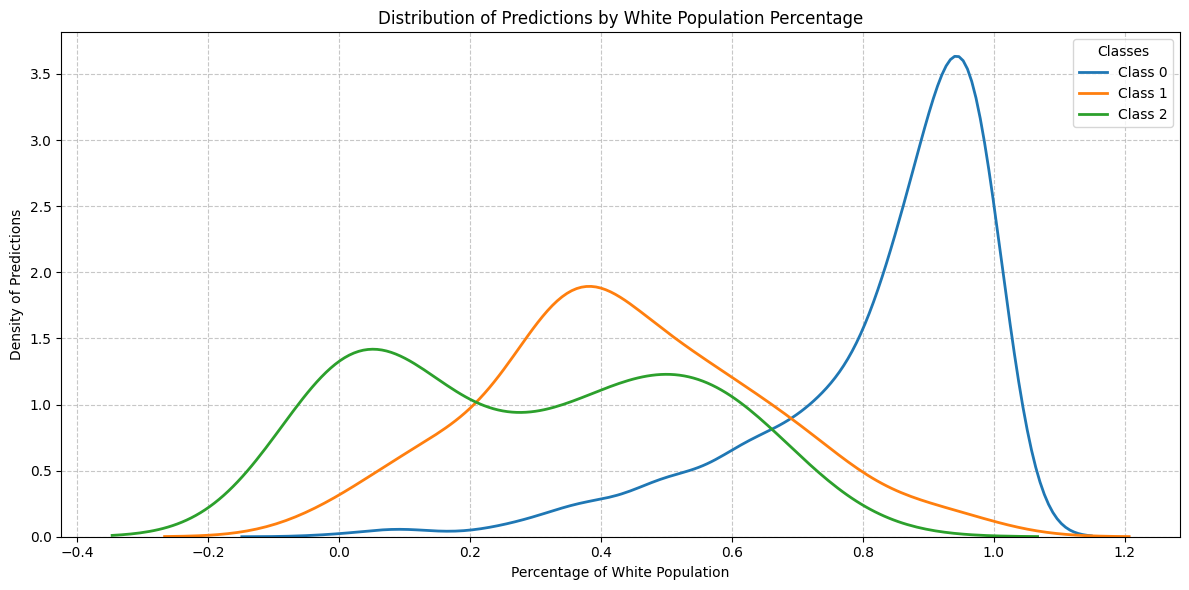

In [26]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_pred'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_pred'] == cls],
        x="racePctWhite",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of Predictions by White Population Percentage')
plt.xlabel('Percentage of White Population')
plt.ylabel('Density of Predictions')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- **Distribution of Class 0 (Low Risk):**
The blue curve dominates the right side of the graph, where the racePctWhite values are high.
This indicates that in areas with a higher proportion of white population, the model predominantly predicts low-risk crimes.

- **Distribution of Class 1 (Medium Risk):**
In areas with a moderate proportion of white population, the model more frequently predicts medium-risk crimes.
The density is relatively low both in areas with a low and high proportion of white population, indicating a lower incidence of medium-risk predictions in these extremes.

- **Distribution of Class 2 (High Risk):**
The green curve peaks at low racePctWhite values, and after a brief decrease in the density of predictions, it slightly increases as the proportion of white population rises.
This suggests that in areas with a low percentage of white population, the model predominantly predicts high-risk crimes.
The density for this class is almost nonexistent for values above 0.5 (50% white population).

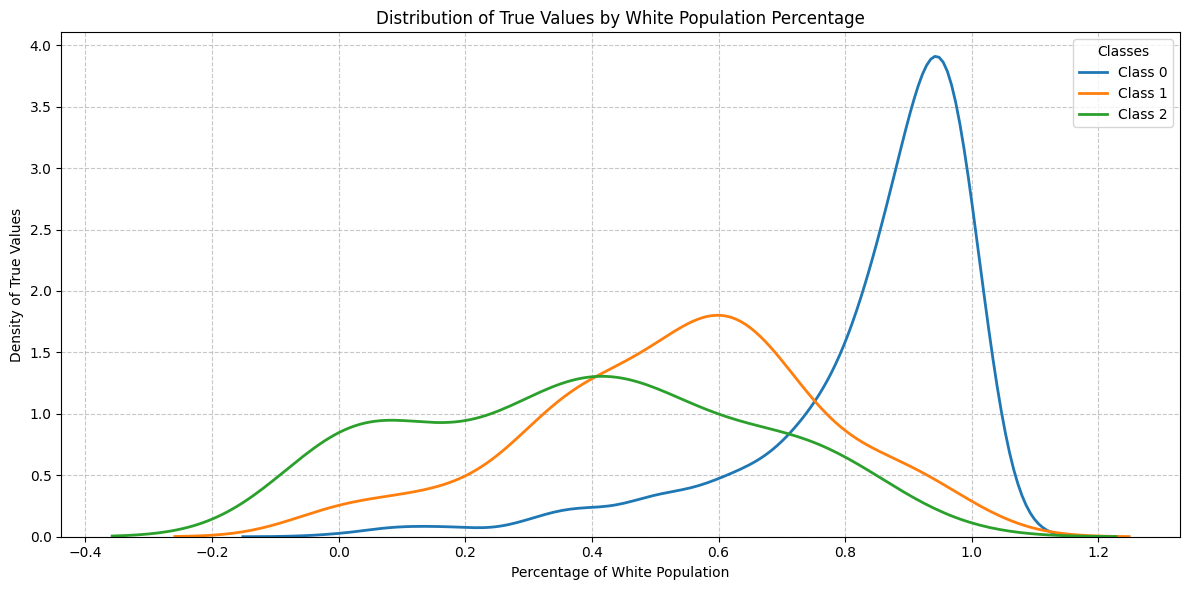

In [27]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_true'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_true'] == cls],
        x="racePctWhite",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of True Values by White Population Percentage')
plt.xlabel('Percentage of White Population')
plt.ylabel('Density of True Values')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Fairness Metrics

In [28]:
# Filtrar os dados para ignorar o grupo "Medium White %"
filtered_groups = ['Low White %', 'High White %']
filtered_data = X_test_with_preds[X_test_with_preds['race_group'].isin(filtered_groups)]

##### Accuracy Parity

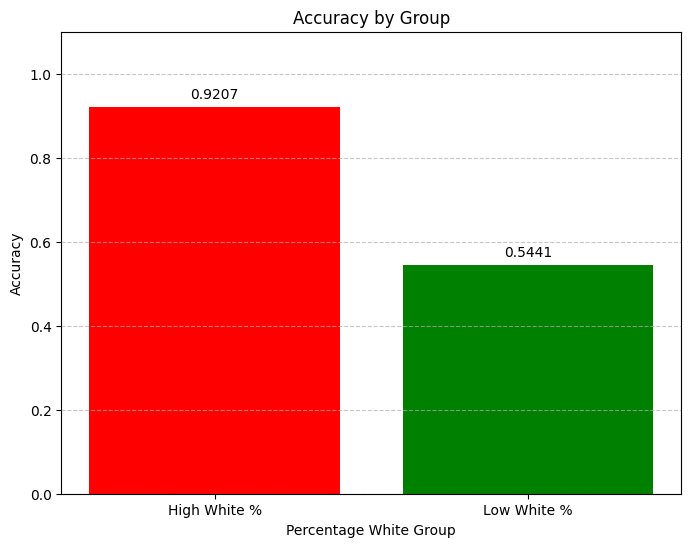

In [29]:
# Calcular a precisão por grupo (apenas para os grupos Low White % e High White %)
accuracies = []
group_labels = filtered_data['race_group'].unique()

for group in filtered_data['race_group'].unique():
    group_data = filtered_data[filtered_data['race_group'] == group]
    group_accuracy = accuracy_score(group_data['y_test_true'], group_data['y_test_pred'])
    accuracies.append(group_accuracy)
    #print(f"Accuracy for {group}: {group_accuracy:.4f}")
# Criar gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(group_labels, accuracies, color=['red', 'green'])

# Adicionar rótulos de precisão no topo de cada barra
for bar, accuracy in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 0.02,           
        f"{accuracy:.4f}",                 
        ha='center',                       
        fontsize=10,                       
        color='black'                      
    )

# Configurações do gráfico
plt.xlabel('Percentage White Group')
plt.ylabel('Accuracy')
plt.title('Accuracy by Group')
plt.ylim(0, 1.1)  # Inclui espaço extra acima para os rótulos
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The accuracy for the High White % group is 0.9207, indicating a high performance of the model when correctly classifying the samples in this group. In contrast, the accuracy for the Low White % group is considerably lower, 0.5441, suggesting that the model has more difficulty correctly classifying samples from this group. This disparity may be indicative of a bias in the model, which may be influenced by specific characteristics of the data related to the Low White % group.

##### **True Positive Rate and False Positive Rate**

In [30]:
# Função para calcular as métricas TPR e FPR para problemas multiclasse
def calculate_metrics(y_true, y_pred, classes_to_consider):
    # Calcular a matriz de confusão usando todas as classes presentes nos dados
    cm = confusion_matrix(y_true, y_pred, labels=classes_to_consider)
    
    tpr_values = []
    fpr_values = []

    for i, class_label in enumerate(classes_to_consider):
        # TPR: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)
        TPR = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) != 0 else 0
        
        # FPR: Falsos Positivos / (Falsos Positivos + Verdadeiros Negativos)
        FPR = np.sum(cm[:, i]) / np.sum(cm) if np.sum(cm[:, i]) != 0 else 0

        tpr_values.append(TPR)
        fpr_values.append(FPR)

    return tpr_values, fpr_values

In [31]:
# Classes que vamos analisar: 0 e 2
classes_to_consider = [0, 2]

# Inicializando listas para armazenar os valores de TPR e FPR para cada classe
tpr_values = {class_label: [] for class_label in classes_to_consider}
fpr_values = {class_label: [] for class_label in classes_to_consider}

# Filtrar os dados para considerar apenas os grupos Low White % e High White % e as classes 0 e 2
filtered_groups = ['Low White %', 'High White %']
filtered_data = X_test_with_preds[X_test_with_preds['race_group'].isin(filtered_groups)]

In [32]:
# Calcular TPR e FPR por classe e grupo
for group in filtered_data['race_group'].unique():
    group_data = filtered_data[filtered_data['race_group'] == group]
    y_true = group_data['y_test_true']
    y_pred = group_data['y_test_pred']
    
    # Calcular as métricas
    tpr, fpr = calculate_metrics(y_true, y_pred, classes_to_consider)
    
    # Adicionar os valores das métricas por classe
    for class_label in classes_to_consider:
        tpr_values[class_label].append(tpr[classes_to_consider.index(class_label)])
        fpr_values[class_label].append(fpr[classes_to_consider.index(class_label)])

# Imprimir os resultados de TPR e FPR
for class_label in classes_to_consider:
    print(f"Class {class_label}:")
    for group, tpr, fpr in zip(filtered_data['race_group'].unique(), tpr_values[class_label], fpr_values[class_label]):
        print(f"  Group: {group}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")

Class 0:
  Group: High White %, TPR: 1.0000, FPR: 1.0000
  Group: Low White %, TPR: 0.6429, FPR: 0.4516
Class 2:
  Group: High White %, TPR: 0.0000, FPR: 0.0000
  Group: Low White %, TPR: 0.7059, FPR: 0.5484


For Class 0:

- The High White % group has a TPR (True Positive Rate) of 1.0000, indicating perfect classification of all Class 0 instances as positive. However, the FPR (False Positive Rate) is also 1.0000, suggesting the model is identifying many false positives, or incorrectly classifying cases as Class 0. 
- In contrast, in the Low White % group, the TPR decreases to 0.6429, showing less accuracy in classification. The FPR (0.4516) remains high, indicating the model still makes significant errors, but to a lesser degree than in the High White % group.

For Class 2:

- The High White % group shows no correct predictions, with both TPR and FPR equal to 0, meaning the model completely fails to identify any instances of Class 2 in the group with a higher percentage of white people. 
- In the Low White % group, the model performs better with a TPR of 0.7059, indicating reasonable detection of Class 2, although the FPR (0.5484) is still relatively high, pointing to a considerable number of false positives.

These results highlight a bias in the model's performance, where it excels at correctly predicting low-risk cases (Class 0) in communities with a higher percentage of white individuals, while it struggles to accurately predict high-risk cases (Class 2), especially in such communities.

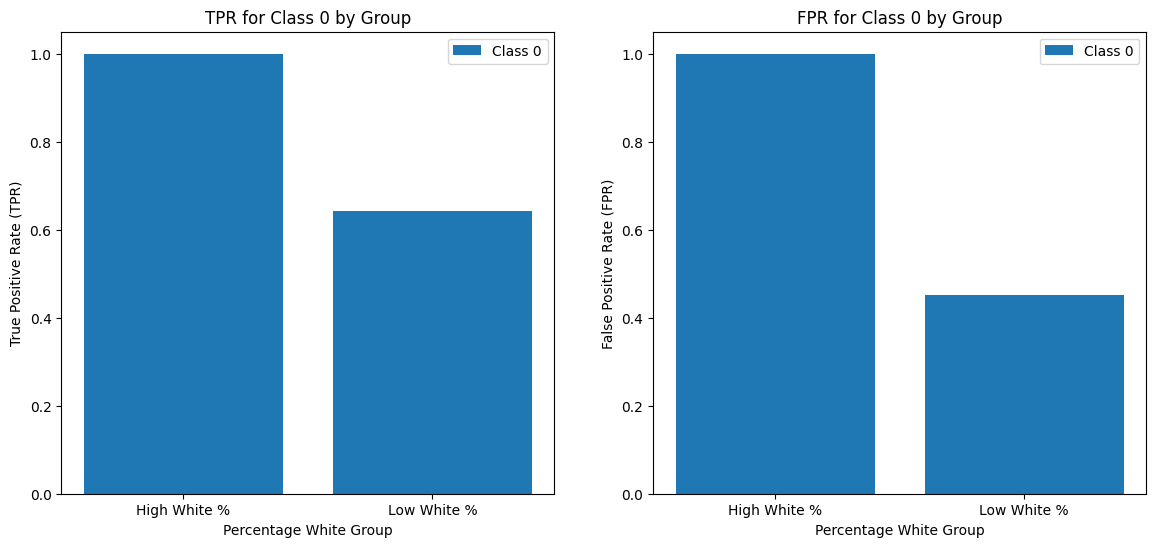

In [33]:
# Criar gráfico de barras para TPR e FPR por grupo e classe
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de TPR para classe 0
axes[0].bar(filtered_data['race_group'].unique(), tpr_values[0], label="Class 0")
axes[0].set_xlabel('Percentage White Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 0 by Group')
axes[0].legend()

# Gráfico de FPR para classe 0
axes[1].bar(filtered_data['race_group'].unique(), fpr_values[0], label="Class 0")
axes[1].set_xlabel('Percentage White Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 0 by Group')
axes[1].legend()

<Figure size 640x480 with 0 Axes>

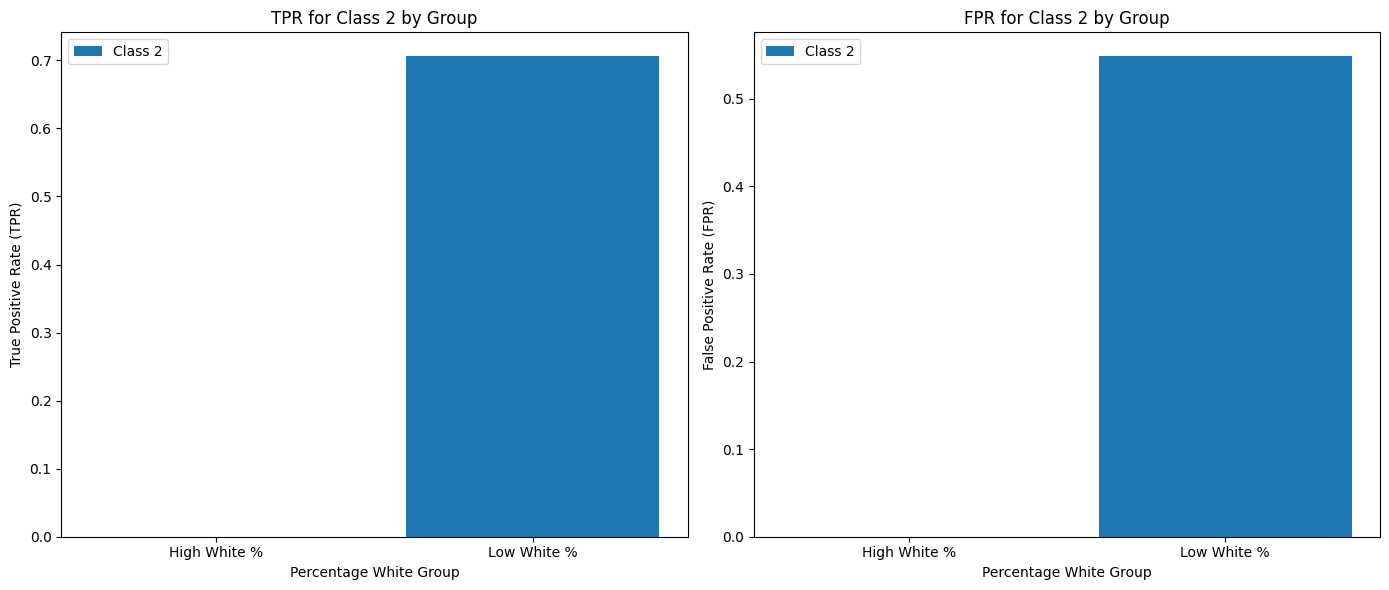

In [34]:
plt.tight_layout()
plt.show()

# Criar gráficos separados para TPR e FPR para a classe 2
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de TPR para classe 2
axes[0].bar(filtered_data['race_group'].unique(), tpr_values[2], label="Class 2")
axes[0].set_xlabel('Percentage White Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 2 by Group')
axes[0].legend()

# Gráfico de FPR para classe 2
axes[1].bar(filtered_data['race_group'].unique(), fpr_values[2], label="Class 2")
axes[1].set_xlabel('Percentage White Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 2 by Group')
axes[1].legend()

plt.tight_layout()
plt.show()

##### Disparate Impact

In [35]:
# Definir os grupos baseados na percentagem de brancos
group_protected = X_test_with_preds[X_test_with_preds['racePctWhite'] > 0.65]
group_non_protected = X_test_with_preds[X_test_with_preds['racePctWhite'] < 0.35]

# Definir o resultado favorável (classe "low risk" = 0)
favorable_outcome = 0

# Calcular a proporção de resultados favoráveis para cada grupo
protected_favorable_rate = (group_protected['y_test_pred'] == favorable_outcome).mean()
non_protected_favorable_rate = (group_non_protected['y_test_pred'] == favorable_outcome).mean()

# Calcular o Disparate Impact
disparate_impact = protected_favorable_rate / non_protected_favorable_rate if non_protected_favorable_rate > 0 else 0

# Exibir os resultados
print("                      LOW-RISK   ")
print(f"Favorable Outcome Rate for High White %: {protected_favorable_rate:.4f}")
print(f"Favorable Outcome Rate for Low White %: {non_protected_favorable_rate:.4f}")
print(f"Disparate Impact: {disparate_impact:.4f}")

                      LOW-RISK   
Favorable Outcome Rate for High White %: 0.9776
Favorable Outcome Rate for Low White %: 0.2623
Disparate Impact: 3.7270


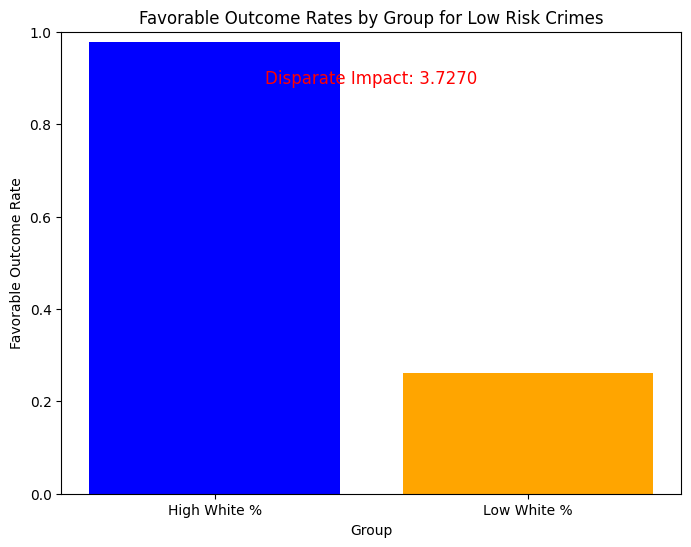

In [36]:
# Data for visualization
groups = ['High White %', 'Low White %']
favorable_rates = [protected_favorable_rate, non_protected_favorable_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, favorable_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for Low Risk Crimes')
plt.xlabel('Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()


**Disparate Impact (DI): 3.7270**

**For Low-Risk:**

The favorable outcome rate for the **High White %** group is 0.9776, meaning that 97.76% of the cases in this group are classified as low risk. In contrast, the **Low White %** group has a much lower favorable outcome rate of 0.2623, indicating that only 26.23% of cases in this group are classified as low risk. The **Disparate Impact** is 3.7270, which indicates a significant disparity between the two groups. The model is much more likely to classify communities with a higher percentage of white people as low risk, while communities with a lower percentage of white people are less likely to be classified as low risk. This suggests that the model may be biased in favor of communities with a higher percentage of white individuals, potentially overestimating the number of low-risk cases in these communities.

In [37]:
# Definir grupos de High Risk
high_risk_class = 2  # Classe "high risk" (assumindo que a classe 2 representa high risk)

# Identificar os grupos baseados na racePctWhite
group_high_white = X_test_with_preds[X_test_with_preds['racePctWhite'] > 0.65]
group_low_white = X_test_with_preds[X_test_with_preds['racePctWhite'] < 0.35]

# Calcular as taxas de resultado favorável para o grupo High Risk
high_white_high_risk_rate = (group_high_white['y_test_pred'] == high_risk_class).mean()
low_white_high_risk_rate = (group_low_white['y_test_pred'] == high_risk_class).mean()

# Calcular o Disparate Impact (DI)
disparate_impact_high_risk = high_white_high_risk_rate / low_white_high_risk_rate

# Exibir os resultados
print("                      HIGH-RISK   ")
print(f"Favorable Outcome Rate for High White %: {high_white_high_risk_rate:.4f}")
print(f"Favorable Outcome Rate for Low White %: {low_white_high_risk_rate:.4f}")
print(f"Disparate Impact (High Risk): {disparate_impact_high_risk:.4f}")

                      HIGH-RISK   
Favorable Outcome Rate for High White %: 0.0017
Favorable Outcome Rate for Low White %: 0.3607
Disparate Impact (High Risk): 0.0048


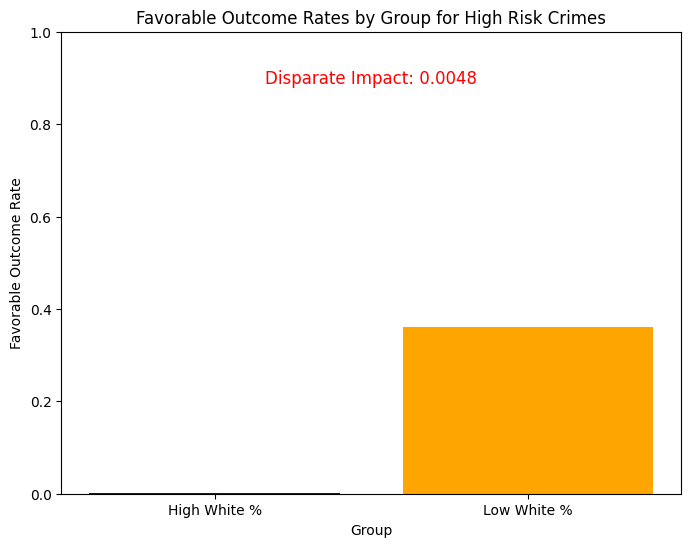

In [38]:
# Data for visualization
groups = ['High White %', 'Low White %']
high_risk_rates = [high_white_high_risk_rate, low_white_high_risk_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, high_risk_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for High Risk Crimes')
plt.xlabel('Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact_high_risk:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()

**Disparate Impact (DI): 0.0048**

**For High-Risk:**

The favorable outcome rate for the **High White %** group is 0.0017, which indicates that only 0.17% of the cases in this group are classified as high risk. In comparison, the **Low White %** group has a much higher favorable outcome rate of 0.3607, meaning that 36.07% of cases in this group are classified as high risk. The **Disparate Impact** is 0.0048, revealing a significant disparity between the two groups. The model is much less likely to classify individuals in communities with a higher percentage of white people as high risk, while communities with a lower percentage of white people are significantly more likely to be classified as high risk. This suggests that the model may be underpredicting high-risk outcomes in communities with a higher percentage of white people, potentially leading to an unfair allocation of resources or interventions.

#### **Fairness Visualization**

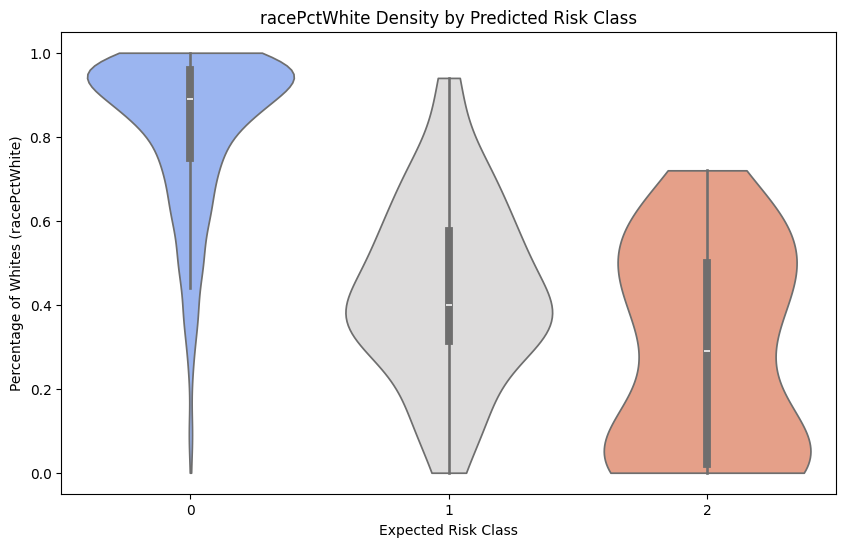

In [39]:
# Violin plot para análise contínua
plt.figure(figsize=(10, 6))
sns.violinplot(x='y_test_pred', y='racePctWhite', data=X_test_with_preds, palette='coolwarm', cut=0)
plt.title('racePctWhite Density by Predicted Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Whites (racePctWhite)')
plt.show()

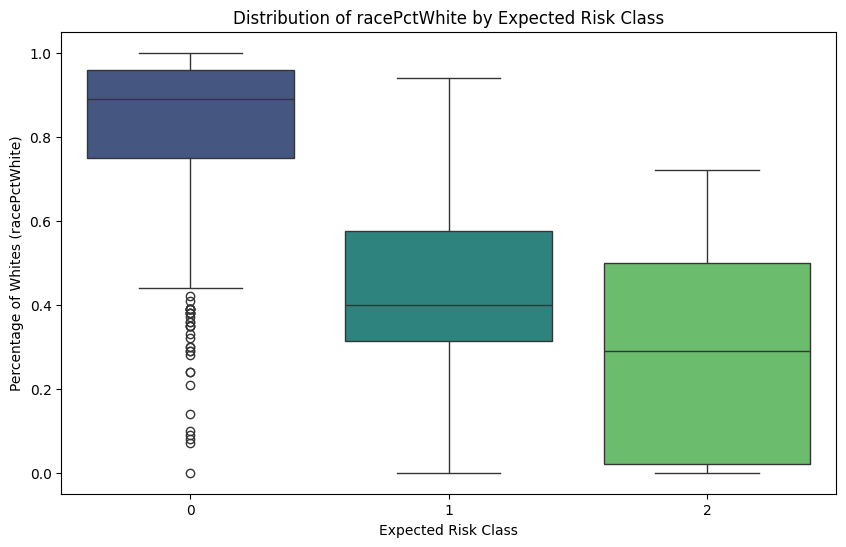

In [40]:
# Boxplot para distribuição de NonracePctWhite por classe de risco prevista
plt.figure(figsize=(10, 6))
sns.boxplot(x='y_test_pred', y='racePctWhite', data=X_test_with_preds, palette='viridis')
plt.title('Distribution of racePctWhite by Expected Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Whites (racePctWhite)')
plt.show()

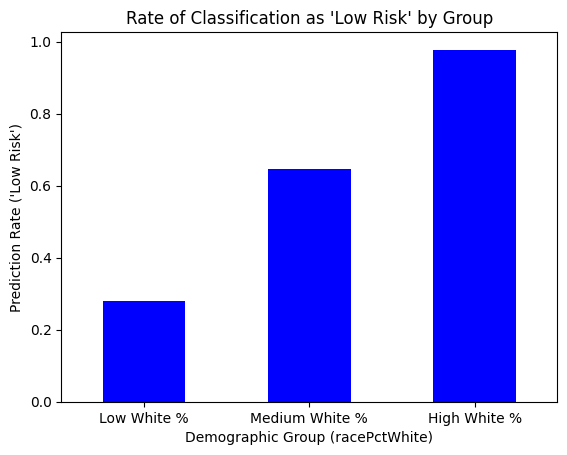

In [41]:
# Taxa de classificação positiva ("Low Risk") por faixa de racePctWhite
positive_rates = X_test_with_preds.groupby('race_group')['y_test_pred'].apply(lambda x: (x == 0).mean())  # 0 representa 'Low Risk'

# Visualizar as taxas
positive_rates.plot(kind='bar', color='blue')
plt.title("Rate of Classification as 'Low Risk' by Group")
plt.xlabel("Demographic Group (racePctWhite)")
plt.ylabel("Prediction Rate ('Low Risk')")
plt.xticks(rotation=0)
plt.show()

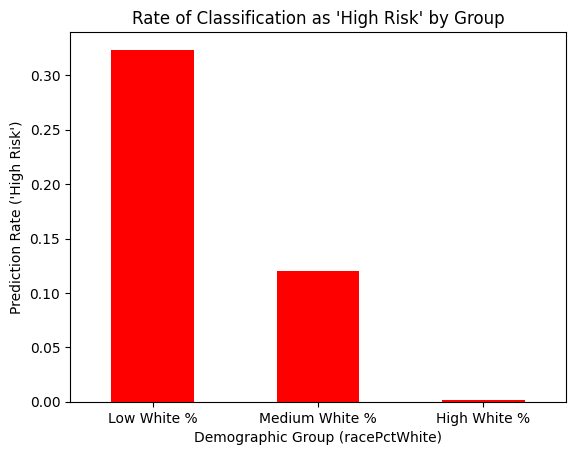

In [42]:
# Taxa de classificação positiva ("High Risk") por faixa de racePctWhite
high_risk_rates = X_test_with_preds.groupby('race_group')['y_test_pred'].apply(lambda x: (x == 2).mean())  # 2 representa 'High Risk'

# Visualizar as taxas para High Risk
high_risk_rates.plot(kind='bar', color='red')
plt.title("Rate of Classification as 'High Risk' by Group")
plt.xlabel("Demographic Group (racePctWhite)")
plt.ylabel("Prediction Rate ('High Risk')")
plt.xticks(rotation=0)
plt.show()

#### **Family Structure Analysis**

**PctIlleg** - Represents the relative proportion of children born to single mothers in relation to the total number of children in the community.

In [43]:
X_test_with_preds['illeg_group'] = pd.cut(
    X_test_with_preds['PctIlleg'], 
    bins=[0.0, 0.35, 0.65, 1.0], 
    labels=['Low Num Childs %', 'Medium Num Childs %', 'High Num Childs %'], 
    include_lowest=True
)

#### Problem overview

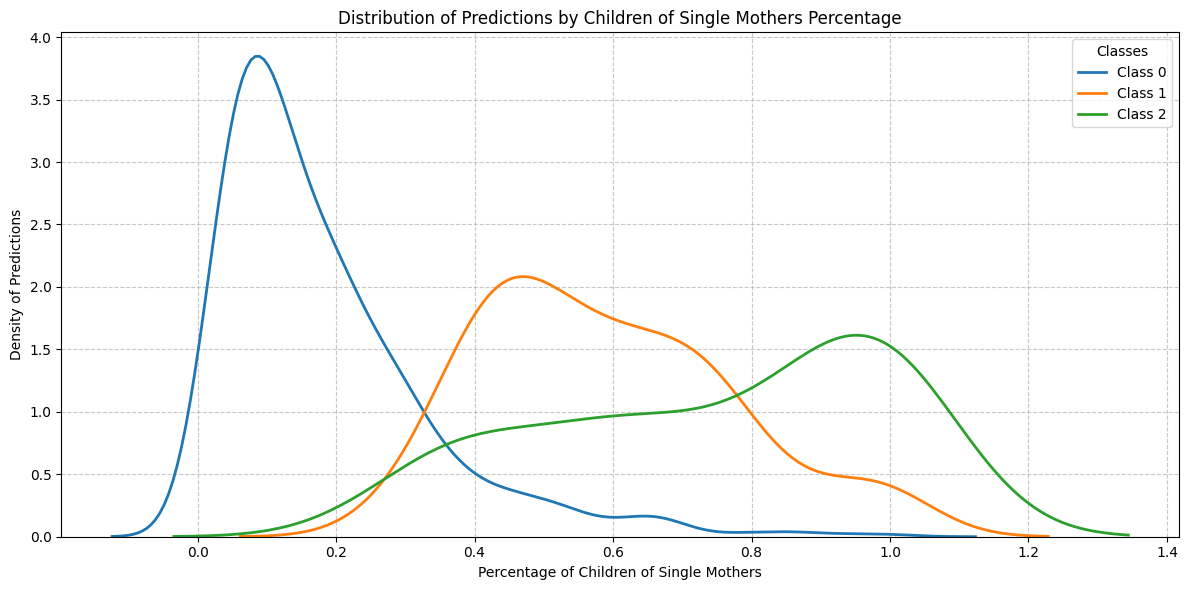

In [44]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_pred'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_pred'] == cls],
        x="PctIlleg",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of Predictions by Children of Single Mothers Percentage')
plt.xlabel('Percentage of Children of Single Mothers')
plt.ylabel('Density of Predictions')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- **Class 0 (blue):** Represents *"low risk"*.

  The density is highest when the value of `PctIlleg` is close to 0, indicating that communities with a low proportion of children born to single mothers tend to be classified as low risk.

- **Class 1 (orange):** Represents *"medium risk"*.

  The density increases when the value of `PctIlleg` is around 0.3 to 0.6.  
  This suggests that communities with moderate proportions of children born to single mothers are classified as medium risk.

- **Class 2 (green):** Represents *"high risk"*.

  The density is higher for `PctIlleg` values above 0.6.  
  Communities with high proportions of children born to single mothers are predominantly classified as high risk.

Thus, the graph suggests that the proportion of children born to single mothers (`PctIlleg`) has a significant correlation with the risk predicted by the model:

- The lower the value of PctIlleg, the higher the likelihood of predictions for *low risk* (Class 0).
- The higher the value of PctIlleg, the higher the likelihood of predictions for *high risk* (Class 2).

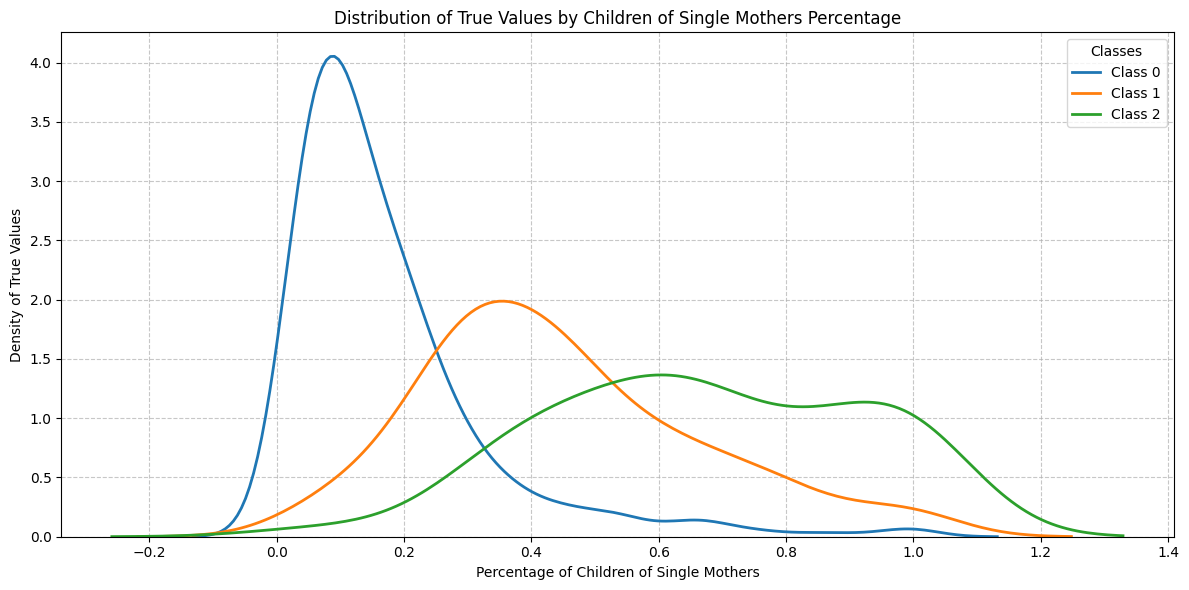

In [45]:
# Criar o gráfico de linhas diretamente com variáveis contínuas
plt.figure(figsize=(12, 6))

# Adicionar manualmente cada curva com rótulo
classes = X_test_with_preds['y_test_true'].unique()
for cls in classes:
    sns.kdeplot(
        data=X_test_with_preds[X_test_with_preds['y_test_true'] == cls],
        x="PctIlleg",
        fill=False,
        common_norm=False,
        label=f"Class {cls}",
        linewidth=2
    )

plt.title('Distribution of True Values by Children of Single Mothers Percentage')
plt.xlabel('Percentage of Children of Single Mothers')
plt.ylabel('Density of True Values')
plt.legend(title='Classes', loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [46]:
# Filtrar os dados para ignorar o grupo "Medium White %"
filtered_groups = ['Low Num Childs %', 'High Num Childs %']
filtered_data = X_test_with_preds[X_test_with_preds['illeg_group'].isin(filtered_groups)]

##### Accuracy Parity

In [47]:
# Calcular a precisão para cada grupo
accuracy_by_illeg_group = X_test_with_preds.groupby('illeg_group').apply(
    lambda x: (x['y_test_pred'] == x['y_test_true']).mean())
print("Accuracy by Illeg Group:")
print(accuracy_by_illeg_group)

Accuracy by Illeg Group:
illeg_group
Low Num Childs %       0.908646
Medium Num Childs %    0.573770
High Num Childs %      0.555556
dtype: float64


For the group with a low percentage of children born to single mothers ("Low Num Childs %"), the model achieves a high accuracy of 0.9086, indicating good performance in predicting outcomes for this group. However, the accuracy decreases for the "Medium Num Childs %" group, with a value of 0.5738, and continues to drop for the "High Num Childs %" group, where the accuracy is 0.5556. **These results suggest that the model struggles more to predict outcomes for communities with higher percentages of children born to single mothers, indicating a potential bias.**

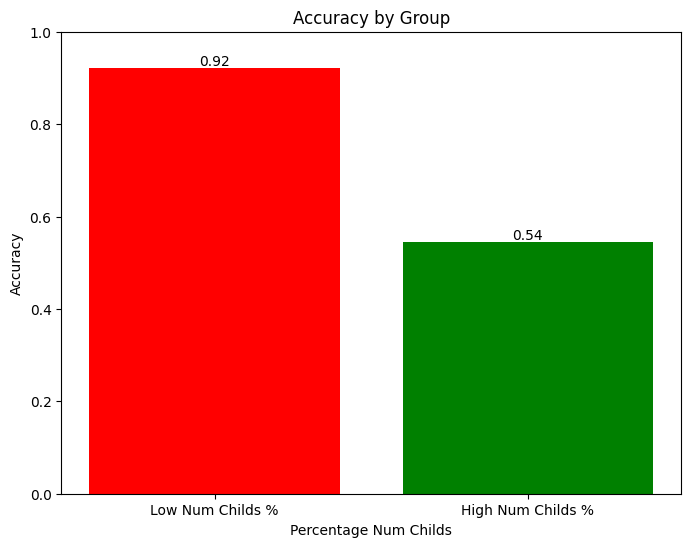

In [48]:
# Criar gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(filtered_data['illeg_group'].unique(), accuracies, color=['red', 'green'])

# Adicionar os valores das precisões acima de cada barra
for bar, accuracy in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # Posição horizontal (centro da barra)
        bar.get_height(),                  # Posição vertical (altura da barra)
        f"{accuracy:.2f}",                 # Valor formatado com 2 casas decimais
        ha='center', va='bottom',          # Centralizado horizontalmente, abaixo do texto
        fontsize=10, color='black'         # Tamanho e cor do texto
    )

plt.xlabel('Percentage Num Childs')
plt.ylabel('Accuracy')
plt.title('Accuracy by Group')
plt.ylim(0, 1)
plt.show()

##### True Positive Rate and False Positive Rate

In [55]:
# Função para calcular as métricas TPR e FPR para problemas multiclasse
def calculate_metrics(y_true, y_pred, classes_to_consider):
    # Calcular a matriz de confusão usando todas as classes presentes nos dados
    cm = confusion_matrix(y_true, y_pred, labels=classes_to_consider)

    tpr_values = []
    fpr_values = []

    for i, class_label in enumerate(classes_to_consider):
        # TPR: Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)
        TPR = cm[i, i] / np.sum(cm[i, :]) if np.sum(cm[i, :]) != 0 else 0

        # FPR: Falsos Positivos / (Falsos Positivos + Verdadeiros Negativos)
        FPR = np.sum(cm[:, i]) / np.sum(cm) if np.sum(cm[:, i]) != 0 else 0

        tpr_values.append(TPR)
        fpr_values.append(FPR)

    return tpr_values, fpr_values


# Classes que vamos analisar: 0 e 2
classes_to_consider = [0, 2]

# Inicializando listas para armazenar os valores de TPR e FPR para cada classe
tpr_values = {class_label: [] for class_label in classes_to_consider}
fpr_values = {class_label: [] for class_label in classes_to_consider}

# Calcular TPR e FPR por classe e grupo
for group in filtered_data['illeg_group'].unique():
    group_data = filtered_data[filtered_data['illeg_group'] == group]
    y_true = group_data['y_test_true']
    y_pred = group_data['y_test_pred']

    # Calcular as métricas
    tpr, fpr = calculate_metrics(y_true, y_pred, classes_to_consider)

    # Adicionar os valores das métricas por classe
    for class_label in classes_to_consider:
        tpr_values[class_label].append(tpr[classes_to_consider.index(class_label)])
        fpr_values[class_label].append(fpr[classes_to_consider.index(class_label)])

# Imprimir os resultados de TPR e FPR
for class_label in classes_to_consider:
    print(f"Class {class_label}:")
    for group, tpr, fpr in zip(filtered_data['illeg_group'].unique(), tpr_values[class_label], fpr_values[class_label]):
        print(f"  Group: {group}, TPR: {tpr:.4f}, FPR: {fpr:.4f}")

Class 0:
  Group: Low Num Childs %, TPR: 1.0000, FPR: 1.0000
  Group: High Num Childs %, TPR: 0.5455, FPR: 0.3226
Class 2:
  Group: Low Num Childs %, TPR: 0.0000, FPR: 0.0000
  Group: High Num Childs %, TPR: 0.8000, FPR: 0.6774


For **Class 0**:

- The model shows high sensitivity (TPR) in the Low Num Childs % group but makes many errors (high FPR).  
- In the High Num Childs % group, the model is more balanced but still exhibits a lower ability to detect Class 0 (lower TPR).  

For **Class 2**:

- The model is unable to predict Class 2 for the Low Num Childs % group.  
- In the High Num Childs % group, the model performs well in identifying Class 2 (high TPR) but still produces many false positives (high FPR).  

These results suggest that the model exhibits biases and inconsistencies in performance across groups and classes, with greater difficulty in handling communities with a low proportion of children born to single mothers for Class 2 and a tendency to overestimate Class 0 in the Low Num Childs % group.  

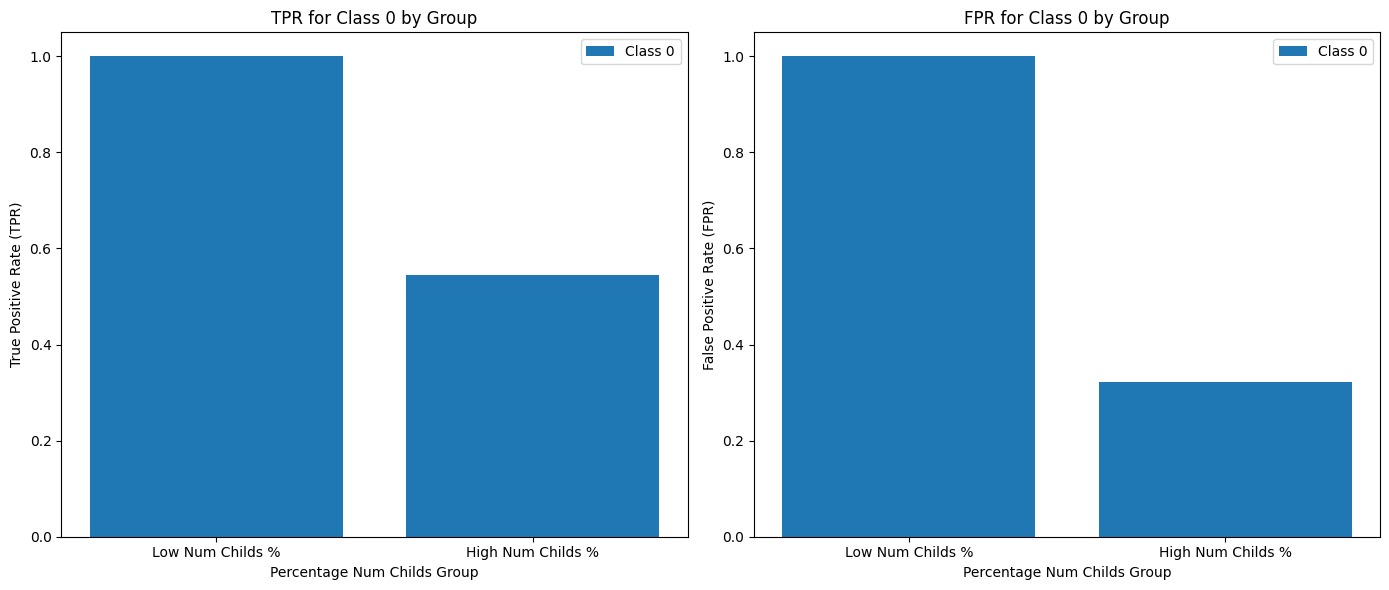

In [56]:
# Criar gráfico de barras para TPR e FPR por grupo e classe
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de TPR para classe 0
axes[0].bar(filtered_data['illeg_group'].unique(), tpr_values[0], label="Class 0")
axes[0].set_xlabel('Percentage Num Childs Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 0 by Group')
axes[0].legend()

# Gráfico de FPR para classe 0
axes[1].bar(filtered_data['illeg_group'].unique(), fpr_values[0], label="Class 0")
axes[1].set_xlabel('Percentage Num Childs Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 0 by Group')
axes[1].legend()
plt.tight_layout()
plt.show()

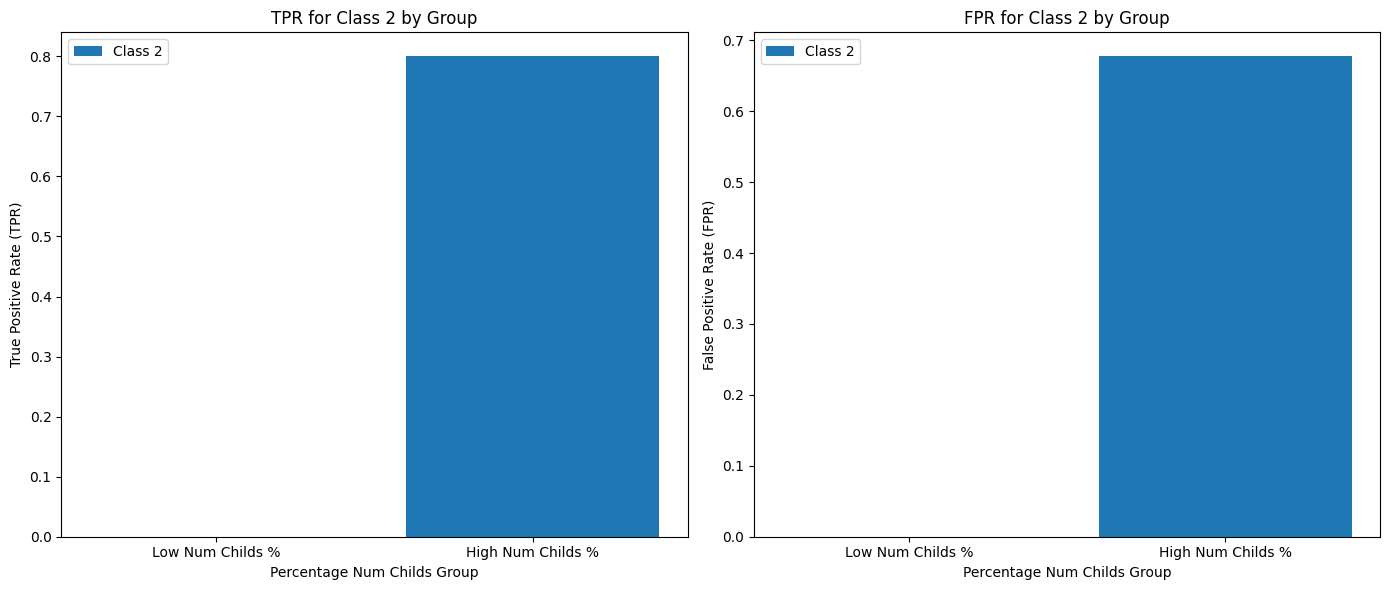

In [57]:
# Criar gráficos separados para TPR e FPR para a classe 2
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de TPR para classe 2
axes[0].bar(filtered_data['illeg_group'].unique(), tpr_values[2], label="Class 2")
axes[0].set_xlabel('Percentage Num Childs Group')
axes[0].set_ylabel('True Positive Rate (TPR)')
axes[0].set_title('TPR for Class 2 by Group')
axes[0].legend()

# Gráfico de FPR para classe 2
axes[1].bar(filtered_data['illeg_group'].unique(), fpr_values[2], label="Class 2")
axes[1].set_xlabel('Percentage Num Childs Group')
axes[1].set_ylabel('False Positive Rate (FPR)')
axes[1].set_title('FPR for Class 2 by Group')
axes[1].legend()

plt.tight_layout()
plt.show()

##### Disparate Impact

                      LOW-RISK   
Favorable Outcome Rate for High Num Childs %: 0.2063
Favorable Outcome Rate for Low Num Childs %: 0.9934
Disparate Impact: 0.2077


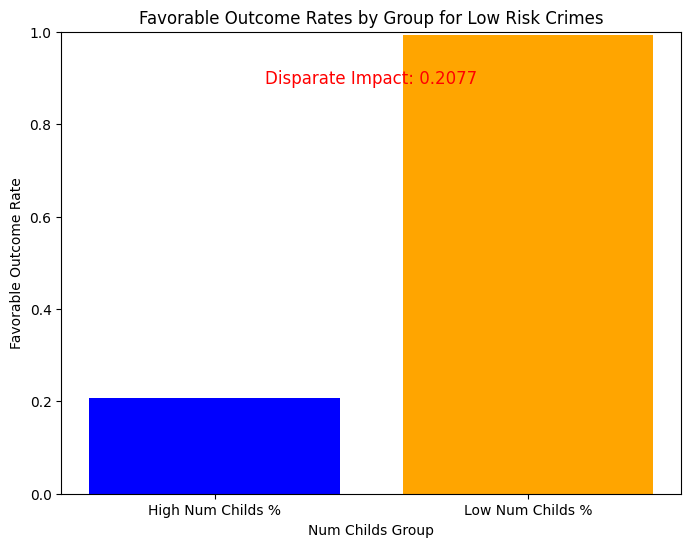

In [58]:
# Definir os grupos baseados na percentagem de brancos
group_protected = X_test_with_preds[X_test_with_preds['PctIlleg'] > 0.65]
group_non_protected = X_test_with_preds[X_test_with_preds['PctIlleg'] < 0.35]

# Definir o resultado favorável (classe "low risk" = 0)
favorable_outcome = 0

# Calcular a proporção de resultados favoráveis para cada grupo
protected_favorable_rate = (group_protected['y_test_pred'] == favorable_outcome).mean()
non_protected_favorable_rate = (group_non_protected['y_test_pred'] == favorable_outcome).mean()

# Calcular o Disparate Impact
disparate_impact = protected_favorable_rate / non_protected_favorable_rate if non_protected_favorable_rate > 0 else 0

# Exibir os resultados
print("                      LOW-RISK   ")
print(f"Favorable Outcome Rate for High Num Childs %: {protected_favorable_rate:.4f}")
print(f"Favorable Outcome Rate for Low Num Childs %: {non_protected_favorable_rate:.4f}")
print(f"Disparate Impact: {disparate_impact:.4f}")
# Data for visualization
groups = ['High Num Childs %', 'Low Num Childs %']
favorable_rates = [protected_favorable_rate, non_protected_favorable_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, favorable_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for Low Risk Crimes')
plt.xlabel('Num Childs Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()

**Disparate Impact (DI): 0.2077**

**For Low-Risk:**

The favorable outcome rate for the High Num Childs % group is 0.2063, indicating that only 20.63% of the cases in this group are classified as low risk. In contrast, the Low Num Childs % group has a favorable outcome rate of 0.9934, meaning that nearly all cases in this group are classified as low risk. The Disparate Impact is 0.2077, showing a significant disparity between the two groups. The model is much less likely to classify communities with a higher percentage of children born to single mothers as low risk, highlighting a potential bias that favors communities with a lower proportion of this characteristic.

                      HIGH-RISK   
Favorable Outcome Rate for High Num Childs %: 0.4127
Favorable Outcome Rate for Low Num Childs %: 0.0017
Disparate Impact (High Risk): 250.0952


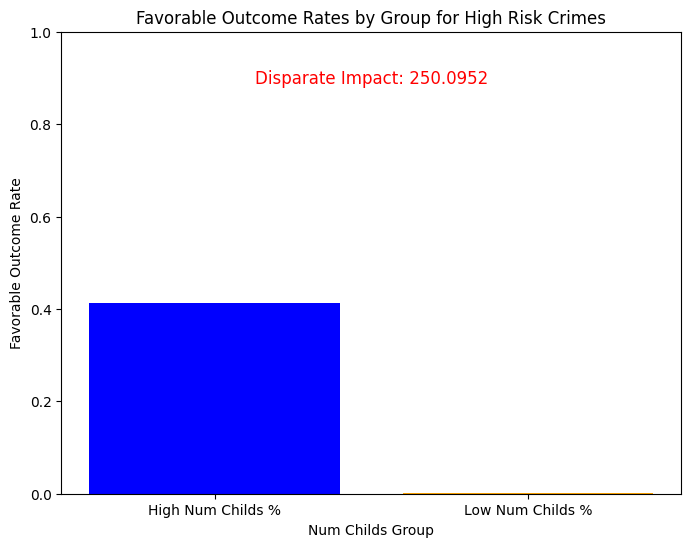

In [59]:
# Definir grupos de High Risk
high_risk_class = 2  # Classe "high risk" (assumindo que a classe 2 representa high risk)

# Identificar os grupos baseados na racePctWhite
group_high_child = X_test_with_preds[X_test_with_preds['PctIlleg'] > 0.65]
group_low_child = X_test_with_preds[X_test_with_preds['PctIlleg'] < 0.35]

# Calcular as taxas de resultado favorável para o grupo High Risk
high_white_high_risk_rate = (group_high_child['y_test_pred'] == high_risk_class).mean()
low_white_high_risk_rate = (group_low_child['y_test_pred'] == high_risk_class).mean()

# Calcular o Disparate Impact (DI)
disparate_impact_high_risk = high_white_high_risk_rate / low_white_high_risk_rate

# Exibir os resultados
print("                      HIGH-RISK   ")
print(f"Favorable Outcome Rate for High Num Childs %: {high_white_high_risk_rate:.4f}")
print(f"Favorable Outcome Rate for Low Num Childs %: {low_white_high_risk_rate:.4f}")
print(f"Disparate Impact (High Risk): {disparate_impact_high_risk:.4f}")
# Data for visualization
groups = ['High Num Childs %', 'Low Num Childs %']
high_risk_rates = [high_white_high_risk_rate, low_white_high_risk_rate]

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(groups, high_risk_rates, color=['blue', 'orange'])

# Add titles and labels
plt.title('Favorable Outcome Rates by Group for High Risk Crimes')
plt.xlabel('Num Childs Group')
plt.ylabel('Favorable Outcome Rate')
plt.ylim(0, 1)

# Annotate the Disparate Impact
plt.text(0.5, 0.9, f"Disparate Impact: {disparate_impact_high_risk:.4f}", ha='center', va='center', fontsize=12, color='red')

# Show the plot
plt.show()

**Disparate Impact (DI): 250.0953**

**For High-Risk:**

The favorable outcome rate for the High Num Childs % group is 0.4127, indicating that 41.27% of the cases in this group are classified as high risk. In contrast, the Low Num Childs % group has a favorable outcome rate of 0.0017, meaning that only 0.17% of cases in this group are classified as high risk. The Disparate Impact is 250.0952, revealing a significant disparity between the two groups. The model is much more likely to classify communities with a higher percentage of children born to single mothers as high risk, while the model almost entirely excludes such classification in communities with a lower proportion of this characteristic. This highlights a strong bias in the model, with a pronounced tendency to favor the High Num Childs % group in predicting high-risk outcomes.

#### Fairness Visualization

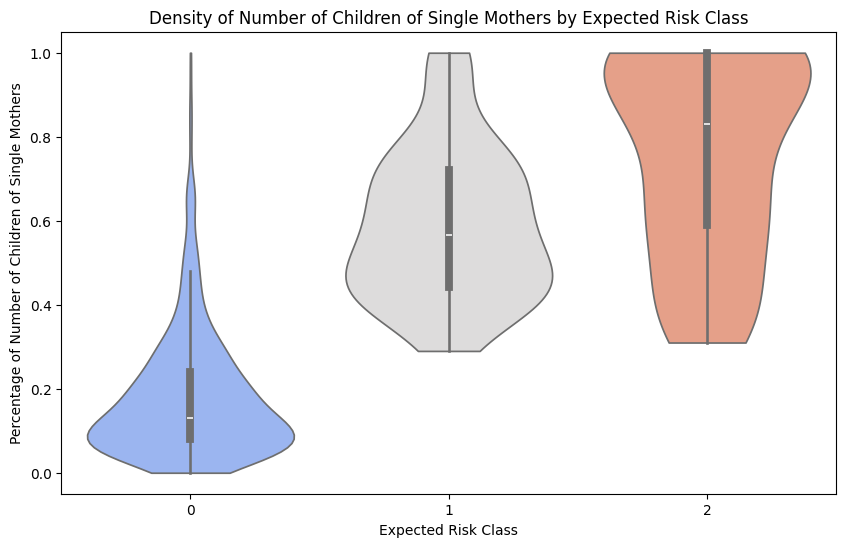

In [60]:
# Violin plot para análise contínua
plt.figure(figsize=(10, 6))
sns.violinplot(x='y_test_pred', y='PctIlleg', data=X_test_with_preds, palette='coolwarm', cut=0)
plt.title('Density of Number of Children of Single Mothers by Expected Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Number of Children of Single Mothers')
plt.show()

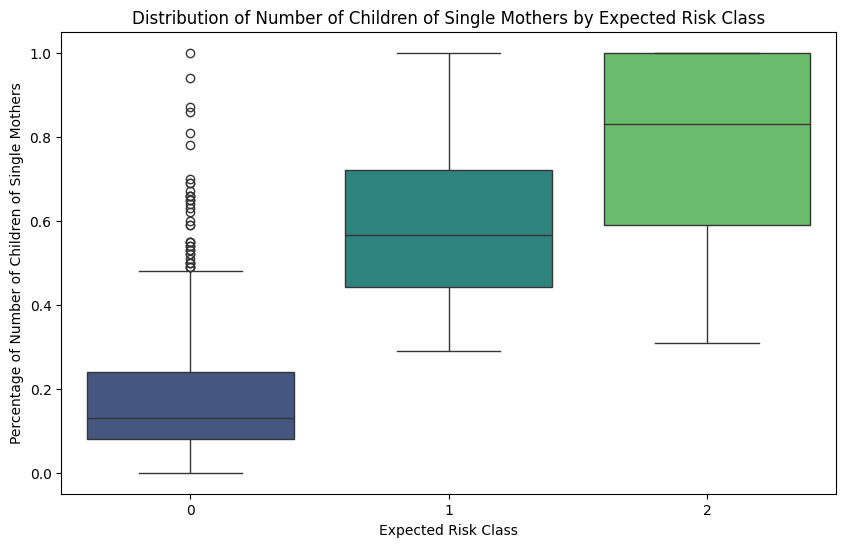

In [62]:
# Boxplot para distribuição de NonracePctWhite por classe de risco prevista
plt.figure(figsize=(10, 6))
sns.boxplot(x='y_test_pred', y='PctIlleg', data=X_test_with_preds, palette='viridis')
plt.title('Distribution of Number of Children of Single Mothers by Expected Risk Class')
plt.xlabel('Expected Risk Class')
plt.ylabel('Percentage of Number of Children of Single Mothers')
plt.show()

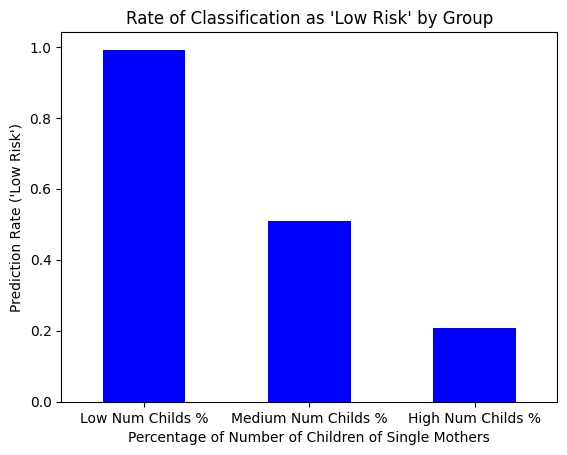

In [61]:
# Taxa de classificação positiva ("Low Risk") por faixa de racePctWhite
positive_rates = X_test_with_preds.groupby('illeg_group')['y_test_pred'].apply(
    lambda x: (x == 0).mean())  # 0 representa 'Low Risk'

# Visualizar as taxas
positive_rates.plot(kind='bar', color='blue')
plt.title("Rate of Classification as 'Low Risk' by Group")
plt.xlabel("Percentage of Number of Children of Single Mothers")
plt.ylabel("Prediction Rate ('Low Risk')")
plt.xticks(rotation=0)
plt.show()

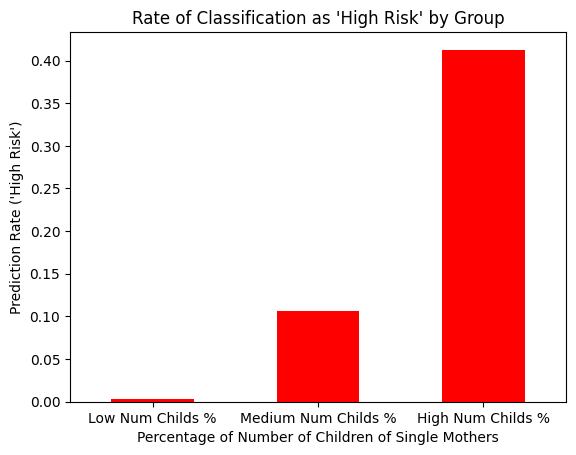

In [63]:
# Taxa de classificação positiva ("High Risk") por faixa de racePctWhite
high_risk_rates = X_test_with_preds.groupby('illeg_group')['y_test_pred'].apply(
    lambda x: (x == 2).mean())  # 2 representa 'High Risk'

# Visualizar as taxas para High Risk
high_risk_rates.plot(kind='bar', color='red')
plt.title("Rate of Classification as 'High Risk' by Group")
plt.xlabel("Percentage of Number of Children of Single Mothers")
plt.ylabel("Prediction Rate ('High Risk')")
plt.xticks(rotation=0)
plt.show()